In [ ]:
!pip install ultralytics
!pip install easyocr
!pip install openai
!pip install matplotlib
!pip install opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.8/872.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.2/374.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.9 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import easyocr
from ultralytics import YOLO
import pandas as pd
import re
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
ROOT_DIR = '/content/gdrive/MyDrive/05 KitaUsahakanMahkotaItu/NutriSmart'
IMAGE_DIR = os.path.join(ROOT_DIR, 'dataset/images/train')
model = YOLO(os.path.join(ROOT_DIR, 'best.pt'))


In [ ]:
reader = easyocr.Reader(['en', 'id'], gpu=False)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:
def process_image(image_path):
    image = cv2.imread(image_path)
    results = model(image)
    boxes = results[0].boxes.xyxy

    nutrition_values = {}
    for box in boxes:
        cropped_image = crop_image(image, box)
        ocr_result = easyocr_ocr_line_by_line(cropped_image)
        values = extract_nutrition_values(ocr_result)
        nutrition_values.update(values)

    return nutrition_values


In [ ]:
def crop_image(image, box):
    x1, y1, x2, y2 = map(int, box)
    return image[y1:y2, x1:x2]

In [ ]:
def easyocr_ocr_line_by_line(image):
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = reader.readtext(rgb_image)

    results.sort(key=lambda x: x[0][0][1])  # Sort by y-coordinate

    lines = []
    current_line = []
    line_threshold = 20

    for result in results:
        bbox, text, _ = result
        top_left_y = bbox[0][1]

        if not current_line:
            current_line.append(text)
            last_y = top_left_y
        else:
            if abs(top_left_y - last_y) <= line_threshold:
                current_line.append(text)
            else:
                lines.append(" ".join(current_line))
                current_line = [text]
            last_y = top_left_y

    if current_line:
        lines.append(" ".join(current_line))

    return "\n".join(lines)

In [ ]:
def extract_nutrition_values(text):
    values = {}
    full_text = ' '.join(text.split('\n'))

    patterns = {
        'takaran-saji': r'Takaran Saji[: ]+(\d+)\s*(\w+)',
        'sajian-per-kemasan': r'Sajian Per Kemasan[: ]+(\d+)',
        'Gula': r'Gula[: ]+(\d+)\s*g',
        'Garam': r'Garam\s*\(Natrium\)[: ]+(\d+)\s*mg',
        'Lemak': r'Lemak\s*Total[: ]+(\d+\.?\d*)\s*g'
    }

    for key, pattern in patterns.items():
        match = re.search(pattern, full_text, re.IGNORECASE)
        if match:
            if key == 'takaran-saji':
                values[key] = f"{match.group(1)} {match.group(2)}"
            else:
                values[key] = match.group(1)

    return values

In [ ]:
def display_boxes(image, boxes):
    image_with_boxes = image.copy()
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (255, 0, 0), 2)
    plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.title("Image with Bounding Boxes")
    plt.show()

In [ ]:
predictions = []
for filename in os.listdir(IMAGE_DIR):
    if filename.endswith('.jpg'):
        image_id = filename.split('.')[0]
        image_path = os.path.join(IMAGE_DIR, filename)

        # Display bounding boxes
        image = cv2.imread(image_path)
        results = model(image)
        boxes = results[0].boxes.xyxy

        nutrition_values = process_image(image_path)
        nutrition_values['Id'] = image_id
        predictions.append(nutrition_values)

        print(f"Processed Image {image_id}: {nutrition_values}")



0: 640x384 1 nutrition-table, 320.6ms
Speed: 18.5ms preprocess, 320.6ms inference, 21.9ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 nutrition-table, 142.0ms
Speed: 5.0ms preprocess, 142.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)
Processed Image 429: {'Garam': '25', 'Id': '429'}

0: 640x480 2 nutrition-tables, 161.6ms
Speed: 3.9ms preprocess, 161.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 2 nutrition-tables, 161.4ms
Speed: 3.8ms preprocess, 161.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)
Processed Image 36: {'Id': '36'}

0: 640x384 (no detections), 145.7ms
Speed: 5.1ms preprocess, 145.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 127.6ms
Speed: 5.1ms preprocess, 127.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)
Processed Image 27: {'Id': '27'}

0: 640x384 1 nutrition-table, 147.3ms
Speed: 5.2ms preprocess

In [ ]:
predictions_df = pd.DataFrame(predictions)

In [ ]:
predictions_df.to_csv('predictions_easyocr.csv', index=False)
print("Predictions saved to 'predictions_easyocr.csv'")

Predictions saved to 'predictions_easyocr.csv'


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
ground_truth = pd.read_csv('/content/gdrive/MyDrive/05 KitaUsahakanMahkotaItu/NutriSmart/dataset-mbdk.csv')
predictions = pd.read_csv('/content/predictions_easyocr.csv')

In [ ]:
merged_df = pd.merge(ground_truth, predictions, on='Id', suffixes=('_true', '_pred'))

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Id                       400 non-null    float64
 1   takaran-saji_true        400 non-null    float64
 2   sajian-per-kemasan_true  399 non-null    float64
 3   Gula_true                400 non-null    float64
 4   Garam_true               400 non-null    float64
 5   Lemak_true               400 non-null    object 
 6   Garam_pred               29 non-null     float64
 7   Gula_pred                22 non-null     float64
 8   takaran-saji_pred        78 non-null     object 
 9   Lemak_pred               12 non-null     float64
 10  sajian-per-kemasan_pred  35 non-null     float64
dtypes: float64(9), object(2)
memory usage: 34.5+ KB


In [ ]:
components = ['takaran-saji', 'sajian-per-kemasan', 'Gula', 'Garam', 'Lemak']

In [ ]:
def evaluate_component(component):
    y_true = merged_df[f'{component}_true'].astype(str)
    y_pred = merged_df[f'{component}_pred'].astype(str)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate accuracy
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)

    # Generate classification report
    report = classification_report(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {component}')
    plt.show()

    print(f"Evaluation for {component}:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Classification Report:\n{report}\n")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

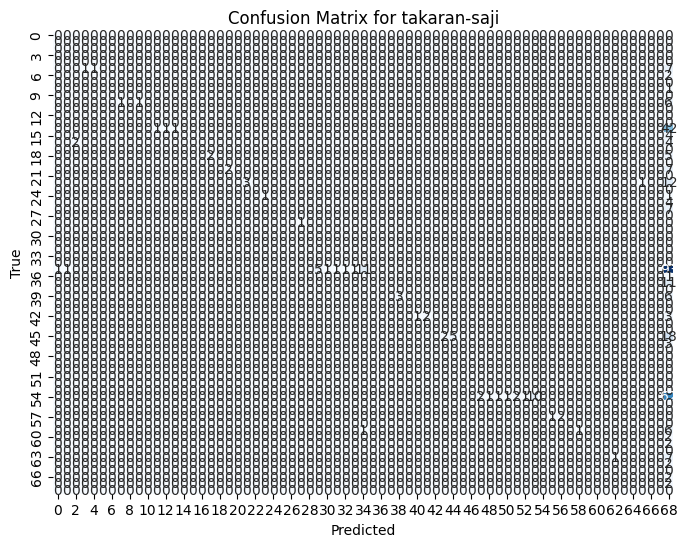

Evaluation for takaran-saji:
Accuracy: 0.00
Classification Report:
              precision    recall  f1-score   support

     1 Kotak       0.00      0.00      0.00       0.0
    1 Sajian       0.00      0.00      0.00       0.0
     1 botol       0.00      0.00      0.00       0.0
      1 oomi       0.00      0.00      0.00       0.0
      100 ml       0.00      0.00      0.00       0.0
       100.0       0.00      0.00      0.00       9.0
       105.0       0.00      0.00      0.00       2.0
      11 Sml       0.00      0.00      0.00       0.0
       110.0       0.00      0.00      0.00       1.0
      115 ml       0.00      0.00      0.00       0.0
       115.0       0.00      0.00      0.00       8.0
      12 Sml       0.00      0.00      0.00       0.0
      125 Ml       0.00      0.00      0.00       0.0
       125 m       0.00      0.00      0.00       0.0
       125.0       0.00      0.00      0.00      45.0
       130.0       0.00      0.00      0.00       4.0
       140.0  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

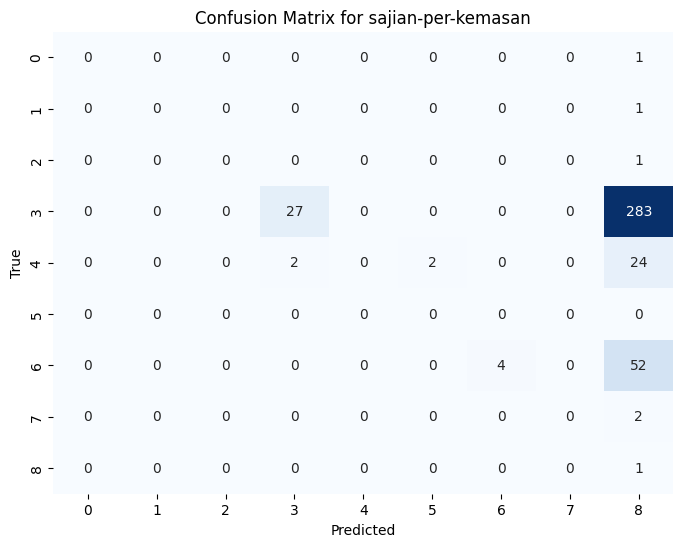

Evaluation for sajian-per-kemasan:
Accuracy: 0.08
Classification Report:
              precision    recall  f1-score   support

         0.5       0.00      0.00      0.00         1
         0.6       0.00      0.00      0.00         1
         0.8       0.00      0.00      0.00         1
         1.0       0.93      0.09      0.16       310
         1.5       0.00      0.00      0.00        28
        15.0       0.00      0.00      0.00         0
         2.0       1.00      0.07      0.13        56
         2.5       0.00      0.00      0.00         2
         nan       0.00      1.00      0.01         1

    accuracy                           0.08       400
   macro avg       0.21      0.13      0.03       400
weighted avg       0.86      0.08      0.14       400




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

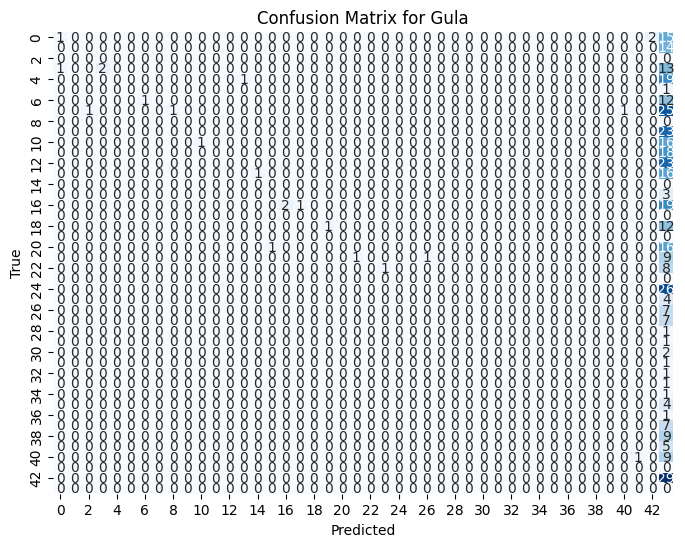

Evaluation for Gula:
Accuracy: 0.02
Classification Report:
              precision    recall  f1-score   support

         0.0       0.50      0.06      0.10        18
        10.0       0.00      0.00      0.00        14
      1079.0       0.00      0.00      0.00         0
        11.0       1.00      0.12      0.22        16
        12.0       0.00      0.00      0.00        20
       12.44       0.00      0.00      0.00         1
        13.0       1.00      0.08      0.14        13
        14.0       0.00      0.00      0.00        28
       149.0       0.00      0.00      0.00         0
        15.0       0.00      0.00      0.00        23
        16.0       1.00      0.06      0.11        17
        17.0       0.00      0.00      0.00        18
        18.0       0.00      0.00      0.00        23
        19.0       0.00      0.00      0.00        17
       199.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         3
        20.0       1.0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

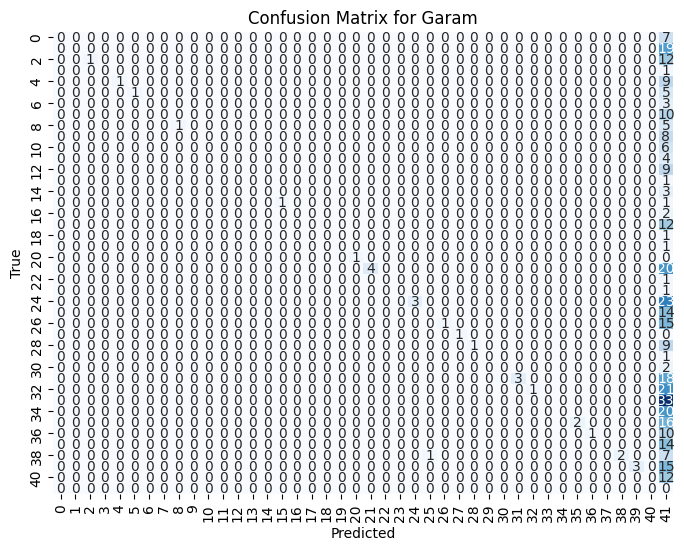

Evaluation for Garam:
Accuracy: 0.07
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
        10.0       0.00      0.00      0.00        19
       100.0       1.00      0.08      0.14        13
      101.66       0.00      0.00      0.00         1
       105.0       1.00      0.10      0.18        10
       110.0       1.00      0.17      0.29         6
       115.0       0.00      0.00      0.00         3
       120.0       0.00      0.00      0.00        10
       125.0       1.00      0.17      0.29         6
       130.0       0.00      0.00      0.00         8
       140.0       0.00      0.00      0.00         6
        15.0       0.00      0.00      0.00         4
       150.0       0.00      0.00      0.00         9
       160.0       0.00      0.00      0.00         1
       170.0       0.00      0.00      0.00         3
       180.0       1.00      0.50      0.67         2
       190.0       0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

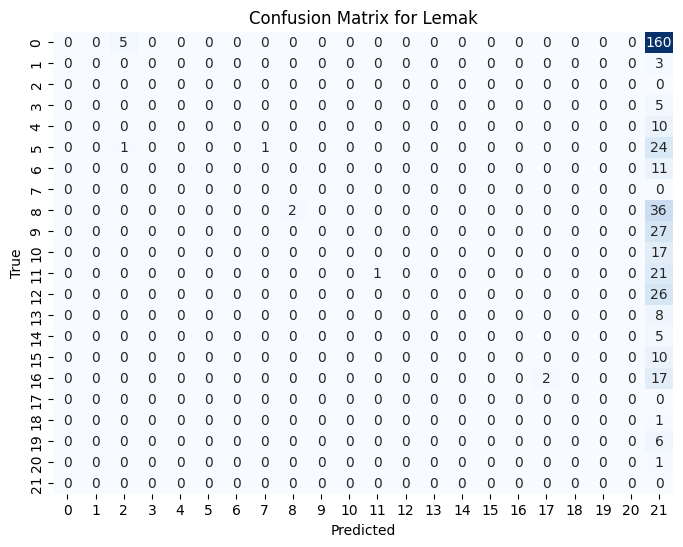

Evaluation for Lemak:
Accuracy: 0.01
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       165
         0,5       0.00      0.00      0.00         3
         0.0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         5
         1.5       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        26
         2,5       0.00      0.00      0.00        11
         2.0       0.00      0.00      0.00         0
         2.5       1.00      0.05      0.10        38
           3       0.00      0.00      0.00        27
         3,5       0.00      0.00      0.00        17
         3.5       1.00      0.05      0.09        22
           4       0.00      0.00      0.00        26
         4,5       0.00      0.00      0.00         8
         4.5       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        10
           6       0.

In [ ]:
for component in components:
    evaluate_component(component)